<img src="https://pages.cnpem.br/capsuladaciencia/wp-content/uploads/sites/155/2022/10/Ilum.png" alt="Ilum - Escola de Ciência" width="200"/>

**Redes Neurais e Algoritmos Genéticos 2025**

**Prof. Dr. Daniel R. Cassar**

Rafael Dalacorte Erdmann (24017)

## Fera Formidável 2: Stop right now, thank you very much

**Objetivo:** implemente uma estratégia de Parada Antecipada (*Early Stopping*) no processo de treino da rede neural feita em Python puro ou no processo de treino da rede neural feita em `PyTorch`.

**Comentário:** esta não é para resolver com o módulo `lightning`.

### Introdução

A estratégia de parada antecipada é um método heurístico de regularização da rede, feito com o intuito principal de evitar *overfitting*. Há maneiras diferentes de definir o critério de parada, como o número de épocas de treinamento [1] ou o momento em que a perda de um set de validação comece a crescer (significando que o modelo está começando a sofrer *overfit*) [2]. 

O código da rede neural feita em Python puro nas aulas já estava baseado em um número de épocas de treinamento, de modo que para resolver esse problema iremos implementar o critério de parada do *validation set*.

### Definição das Classes

Não há nada de novo nessa etapa, é apenas a importação das classes `Valor`, `Neurônio`, `Camada` e `MLP` já presentes em atividades anteriores.

In [367]:
import random
import numpy as np

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]
    
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for i in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios 
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP:   
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.epocas = 0
        self.curva_treino = []
        self.curva_validacao = []
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

### Novos dados

Os dados utilizados para treino da rede MLP serão os dados didáticos de pinguins disponíveis no Seaborn.

In [368]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns

SEMENTE_ALEATORIA = 42
random.seed(SEMENTE_ALEATORIA)

TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.2

dados = sns.load_dataset("penguins")
dados = dados.dropna().reset_index()

FEATURES = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'species']
TARGETS = ['body_mass_g']

# conversão simbólico-numérico dos features sexo e espécie
for feature in ['sex','species']:
    x = dados[feature]

    ordem = [x.unique()]
    encoder = OrdinalEncoder(categories=ordem)

    ## ajuste dos dados
    x = x.values.reshape((-1,1))
    encoder.fit(x)

    ## conversão dos dados
    dados_convertidos = encoder.transform(x)
    dados[feature] = dados_convertidos
#

# normalização minmax
conversao = {}

for variavel in FEATURES+TARGETS:
    maximo = dados[variavel].max()
    minimo = dados[variavel].min()

    conversao[variavel+"_min"] = minimo
    conversao[variavel+"_max"] = maximo

    dados[variavel] = (dados[variavel] - minimo) / (maximo - minimo)

def reconversao(y_norm, minimo, maximo):
        y_real = y_norm * (maximo - minimo) + minimo
        return y_real
#

# Tratamento dos dados
x = dados.reindex(FEATURES, axis=1)
y_true = dados.reindex(TARGETS, axis=1).values

indices = range(len(x))
indices_treinamento, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=42
)

indices_treino, indices_val = train_test_split(
    indices_treinamento, test_size=TAMANHO_VALIDACAO, random_state=42
)

x_treino = x.loc[indices_treino].values.tolist()
y_true_treino = y_true[indices_treino].reshape(-1,1)

x_val = x.loc[indices_val].values.tolist()
y_true_val = y_true[indices_val].reshape(-1,1)

x_teste = x.loc[indices_teste].values.tolist()
y_true_teste = y_true[indices_teste].reshape(-1,1)
#

In [ ]:
# Arquitetura da rede neural
NUM_DADOS_DE_ENTRADA = len(FEATURES)  
NUM_DADOS_DE_SAIDA = len(TARGETS)    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)
#

### Treinamento em épocas

Aqui está de fato a implementação do critério de parada: ao final da época, após ter salvo uma curva de validação (conforme Monstrinho 6), o algoritmo checa se o último *loss* de validação está maior do que a média dos 7 *losses* anteriores, levando em conta o arredondamento para um número específico de decimais (parâmetro `decimais_precisao`).

In [383]:
def treino_epocas(mlp:MLP, x_treino:list, x_val:list, y_true_treino:list, y_true_val:list, taxa_de_aprendizado:float, decimais_precisao:int, iter_max=1000):
    """Função que realiza o treinamento em épocas de uma rede neural MLP. Implementa dois critérios de parada: caso os gradientes das últimas 5 épocas de treinamento sejam iguais à média das últimas 10 épocas (com precisão decimais_precisao), ou caso o número de épocas alcance o limite iter_max.
    
    Args:
        mlp: instância da classe MLP
        x_treino: lista com valores de features destinadas para treino
        x_val: lista com valores de features destinadas para validação
        y_true_treino: lista com valores de targets associados a cada linha de features dos dados de treino
        y_true_val: lista com valores de targets associados a cada linha de features dos dados de validação
        taxa_de_aprendizado: taxa de aprendizado do modelo, recomenda-se usar por volta de 0.5
        decimais_precisao: número de valores decimais considerados no critério de parada (quanto mais decimais, mais custo computacional)
        iter_max: número máximo de iterações caso o modelo não consiga convergir
        
    Returns:
        não há retorno, a função atualiza os parâmetros da instância mlp"""

    curva_treino = []
    curva_validacao = []

    num_epocas = 0

    for _ in range(iter_max):
        # forward pass
        ## forward pass do treino
        y_pred_treino = []

        for exemplo in x_treino:
            previsao = mlp(exemplo)
            y_pred_treino.append(previsao)

        ## forward pass da validação
        y_pred_val = []

        for exemplo in x_val:
            previsao = mlp(exemplo)
            y_pred_val.append(previsao)

        # loss
        ## loss do treino (RMSE)
        erros_treino = []
        for yt, yp in zip(y_true_treino, y_pred_treino):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_treino.append(erro_quadratico)
        loss_treino = (sum(erros_treino)/len(y_true_treino))**(1/2)

        ## loss da validação (RMSE)
        erros_val = []
        for yt, yp in zip(y_true_val, y_pred_val):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_val.append(erro_quadratico)
        loss_val = (sum(erros_val)/len(y_true_val))**(1/2)

        # zero grad
        for p in mlp.parametros():
            p.grad = 0

        # backpropagation
        loss_treino.propagar_tudo()

        # atualiza parâmetros
        for p in mlp.parametros():
            p.data = p.data - p.grad * taxa_de_aprendizado

        # SALVA o resultado
        curva_treino.append(loss_treino.data)
        curva_validacao.append(loss_val.data)
        num_epocas += 1 

        # checa o critério de parada
        if decimais_precisao:
            if num_epocas > 7:
                if round(float(curva_validacao[-1]),decimais_precisao) >= round(np.mean(curva_validacao[-7:-1]), decimais_precisao):
                    break

    mlp.epocas += num_epocas
    mlp.curva_treino += curva_treino
    mlp.curva_validacao += curva_validacao

In [370]:
TAXA_DE_APRENDIZADO = 1
DECIMAIS_PRECISAO = 6

treino_epocas(minha_mlp, x_treino, x_val, y_true_treino, y_true_val, 
              TAXA_DE_APRENDIZADO, DECIMAIS_PRECISAO, iter_max=1000)

Plotando a curva de aprendizado do teste

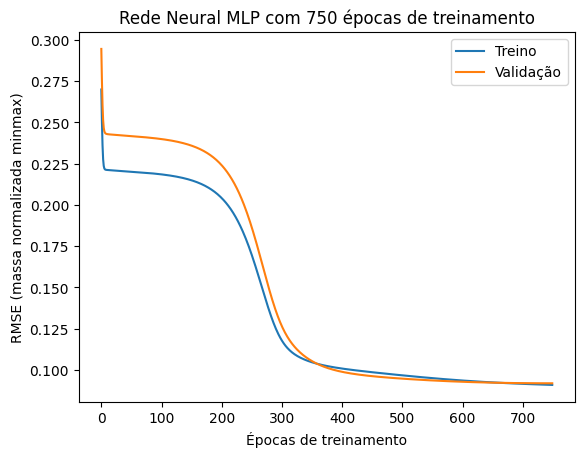

In [380]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

axes.plot(range(minha_mlp.epocas), minha_mlp.curva_treino, label="Treino")
axes.plot(range(minha_mlp.epocas), minha_mlp.curva_validacao, label="Validação")
axes.set_title(f"Rede Neural MLP com {minha_mlp.epocas} épocas de treinamento")
axes.set_ylabel("RMSE (massa normalizada minmax)")
axes.set_xlabel("Épocas de treinamento")
axes.legend()
plt.show()

Agora vamos checar qual o erro do nosso modelo ao prever dados que ele não viu: o set de teste.

In [379]:
y_pred = []

for x in x_teste:
    previsao = minha_mlp(x)
    y_pred.append(previsao)

erros_teste = []
for yt, yp in zip(y_true_teste, y_pred):
    residuo = yp - yt
    erro_quadratico = residuo ** 2
    erros_teste.append(erro_quadratico)
loss_teste = (sum(erros_teste)/len(y_true_teste))**(1/2)

print('COMPARAÇÃO:', f'RMSE treino: {minha_mlp.curva_treino[-1]}', f'RMSE validação: {minha_mlp.curva_validacao[-1]}', f'RMSE teste: {loss_teste.data}', sep="\n")

COMPARAÇÃO:
RMSE treino: [0.09085403]
RMSE validação: [0.09184854]
RMSE teste: [0.08245193]


Portanto, a perda ficou semelhante à perda dos dados de treino e de validação na última época do modelo, indicando que o *overfit* foi evitado.

Para isso, a rede teve que ser treinada com uma taxa de aprendizado alta ($= 1$) para conseguir superar o *plateau* de perda que durou até a época $200$. 

Podemos, ainda, continuar treinando a rede para observar (apenas com objetivo didático, claro que isso seria excessivo para um problema real) qual é o comportamento da perda da validação após o critério de parada:

In [384]:
epoca_parada = minha_mlp.epocas

treino_epocas(minha_mlp, x_treino, x_val, y_true_treino, y_true_val, 
              TAXA_DE_APRENDIZADO, decimais_precisao=None, iter_max=1000-minha_mlp.epocas)

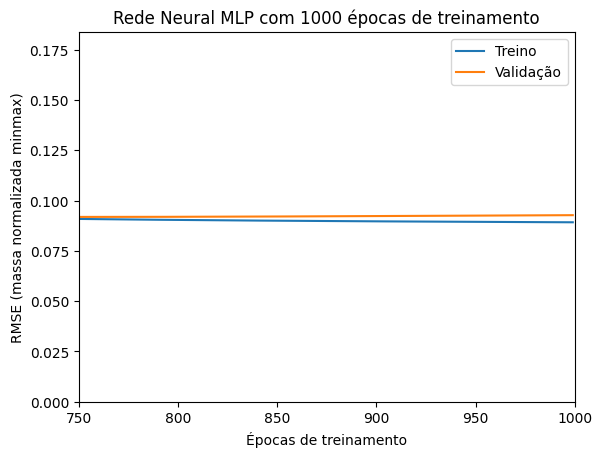

In [396]:
import matplotlib.pyplot as plt

epoca_parada = 750
fig, axes = plt.subplots()

axes.plot(range(minha_mlp.epocas), minha_mlp.curva_treino, label="Treino")
axes.plot(range(minha_mlp.epocas), minha_mlp.curva_validacao, label="Validação")
axes.set_title(f"Rede Neural MLP com {minha_mlp.epocas} épocas de treinamento")
axes.set_ylabel("RMSE (massa normalizada minmax)")
axes.set_xlabel("Épocas de treinamento")
axes.set_xlim(epoca_parada, minha_mlp.epocas)
axes.set_ylim(0, minha_mlp.curva_validacao[-minha_mlp.epocas+epoca_parada-1]*2)
axes.legend()
plt.show()

Ou seja, de fato a perda da validação estava piorando (mesmo que, nesse caso, piorando pouco), sinal de que a rede estava começando a ter *overfit*.

### Conclusão

Com o critério de parada baseado na piora da curva de perda da validação, foi possível evitar custo computacional desnecessário (de treino excessivo do modelo) e garantir que o modelo não sofreu *overfit*.

### Referências

[1] Prince, S. J. D. **Understanding Deep Learning.** 9.3.1: Early Stopping. The MIT Press: 2023.

[2] Hastie, T.; Tibshirani, R.; Friedman, J. **The Elements of Statistical Learning: Data Mining, Inference, and Prediction.** 11.5.2: Overfitting. Springer: 2nd Edition, 2009.